This notebook demonstrates interaction with OpenAI LLM and how we can use the output of UI understanding models (UI detection, icon recognition) to improve the responses to screen Q&A even using text only models. Screen Q&A questions are formulated from this paper: https://arxiv.org/abs/2404.05719

To use this notebook, you will need an OpenAI key and add it into the `tokens.json` file in the root folder for this lecture.  

In [3]:
from openai import OpenAI
import json
import os
from PIL import Image, ImageDraw
import torch 
from screenrecognition.ui_models import *
from screenrecognition.ui_datasets import *

In [4]:
CHECKPOINTS_DIR = "./downloads/checkpoints/"
CHECKPOINT_TO_EVALUATE = "screenrecognition-web350k-vins.ckpt" # Path to a trained screen recogntion model checkpoint.
OPENAI_MODEL = "gpt-4" # Feel free to change to gpt-3.5-turbo, etc, to experiment w/ different models. 

## Helper functions

In [5]:
def getPredictionsForImage(model, image): 
    img_input = image
    if not torch.is_tensor(image):
        img_transforms = transforms.ToTensor()  
        img_input = img_transforms(image)
    
    pred = model.model([img_input])
    return pred

In [6]:
def loadModel(): 
    model_path = os.path.join(CHECKPOINTS_DIR,  CHECKPOINT_TO_EVALUATE)
    m = UIElementDetector.load_from_checkpoint(model_path).eval()
    return m

In [7]:
def loadClassMap(): 
    class_map_file = "metadata/screenrecognition/class_map_vins_manual.json"
    with open(class_map_file, "r") as f:
        class_map = json.load(f)
        
    idx2Label = class_map['idx2Label']
    return idx2Label

In [8]:
class UIObject: 
    def __init__(self, id, x1, y1, x2, y2, label, confidence=1.0, text="", clickable=True):
        self.id = id
        self.x = int(x1) 
        self.y = int(y1)
        self.width = int(x2 - x1)
        self.height = int(y2 - y1) 
        self.label = label 
        self.text = text 
        self.confidence = confidence
        self.clickable = clickable # Whether or not the UI element is interactive

    def to_str(self): 
        return f"UIObject Box: {self.x:.2f}, {self.y:.2f}, {self.width:.2f}, {self.height:.2f},  Class: {self.label},  Label: {self.text}, Score: {self.confidence}"

In [9]:
def getUIObjectsForPredictions(predictions):
    boxes =  pred[0]['boxes']
    scores = pred[0]['scores']
    labels = pred[0]['labels']
    idx2Label = loadClassMap()
        
    uiObjects = []
    for i in range(len(boxes)): 
        score = scores[i]
        if score > 0.5:
            box = boxes[i].tolist()
            label = labels[i] 
            classStr = idx2Label[str(int(label))]
            uiObject = UIObject(i, box[0], box[1], box[2], box[3], classStr, confidence=score) 
            uiObjects.append(uiObject)
    return uiObjects

In [10]:
def drawUIObjectsOnImage(test_image, uiObjects, displayWidth=400): 
     # Resize the image to be more visible in the cell 
    wpercent = (400/float(test_image.size[0]))
    hsize = int((float(test_image.size[1])*float(wpercent)))
    test_image = test_image.resize((400, hsize))

    draw = ImageDraw.Draw(test_image)

    conf_thresh = 0.5
    for i in range(len(uiObjects)):
        uiObject = uiObjects[i]
        if uiObject.confidence > conf_thresh:
            x1 = int(uiObject.x) * wpercent
            y1 = int(uiObject.y) * wpercent
            x2 = int(uiObject.x + uiObject.width) * wpercent
            y2 = int(uiObject.y + uiObject.height) * wpercent
            draw.rectangle([x1, y1, x2, y2], outline='red')
            draw.text((x1, y1), f"{uiObject.label} {uiObject.text} {uiObject.confidence:.2f}", fill="red")
    return test_image

In [11]:
def addOCRToUIObjects(ui_objects, ocr_for_image): 
    for ui_object in ui_objects: 
        for ocr in ocr_for_image: 
            x = ocr["x"]
            y = ocr["y"]
            w = ocr["w"]
            h = ocr["h"]

            # Calculate relevant areas.
            ocr_area = w * h

            left = max(x, ui_object.x)
            top = max(y, ui_object.y)
            right = min(x+w, ui_object.x+ui_object.width)
            bottom = min(y+h, ui_object.y+ui_object.height)
    
            # Calculate the area.
            intersection_width = max(0, right - left)
            intersection_height = max(0, bottom - top)
            intersection = intersection_width * intersection_height
    
            # Check whether we meet the threshold.
            overlap = intersection / ocr_area >= 0.5
            if overlap: 
                ui_object.text = ocr["text"]
    return ui_objects

## Query the OpenAI model

#### Define your tokens

In [12]:
with open("./tokens.json") as f:
    tokens = json.load(f)

os.environ["OPENAI_API_KEY"] = tokens["openai"]

### Test out chat completion 

In [13]:
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
    {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content="In the heart of code, a concept lies,\nWhere function calls itself, oh wise!\nRecursion dances with elegant grace,\nA loop of beauty in a program's embrace.\n\nLike a mirror reflecting a mirror in endless loop,\nIt journeys deep, like a magician's troupe.\nWith each iteration, a call anew,\nUnraveling mysteries, like a wizard true.\n\nA problem divided, conquer by divide,\nRecursive magic, no need to hide.\nSolving puzzles with a recursive spell,\nIn the labyrinth of code, it serves us well.\n\nBut beware, oh coder, tread with care,\nInfinite loops, a lurking snare.\nEnd conditions set, a path to find,\nIn the recursive dance of the programming mind.\n\nSo embrace the beauty, the power, the art,\nOf recursion in code, a work of heart.\nA loop within a loop, a tale to tell,\nIn the realm of programming, where wonders dwell.", role='assistant', function_call=None, tool_calls=None)


### Ask the model a set of questions about user interfaces. Examine it's output. 

In [14]:
# Provide the OCR for the test image
ocr_for_image = [{"confidence":0.5,"x":409,"y":5,"w":120,"h":24,"text":"• N Q 2:09"},
                 {"y":57,"confidence":1,"text":"=","x":20,"w":34,"h":27},
                 {"confidence":1,"h":27,"y":59,"w":62,"x":94,"text":"Shop"},
                 {"confidence":1,"y":131,"text":"All Departments","w":170,"x":23,"h":23},
                 {"w":68,"confidence":1,"text":"Books","h":20,"x":25,"y":196},
                 {"text":"Online Specials","x":25,"h":28,"w":158,"y":259,"confidence":1},
                 {"y":327,"h":19,"confidence":1,"text":"Children's Books","w":169,"x":26},
                 {"text":"Top 200 Books","y":393,"confidence":1,"x":26,"w":155,"h":23},
                 {"y":457,"x":26,"w":194,"h":21,"confidence":1,"text":"Literature & Fiction"},
                 {"h":25,"y":523,"w":266,"confidence":1,"text":"Art, Music & Photography","x":23},
                 {"y":587,"w":260,"confidence":1,"text":"Home, Hobbies & Garden","x":25,"h":25},
                 {"w":226,"h":25,"x":25,"y":653,"confidence":1,"text":"Cooking, Food & Wine"},
                 {"confidence":1,"h":22,"text":"Textbooks","x":25,"y":716,"w":110},
                 {"x":26,"confidence":1,"text":"Adult Coloring Books","w":216,"y":783,"h":25},
                 {"h":21,"x":26,"confidence":1,"text":"Religion","y":851,"w":84}]

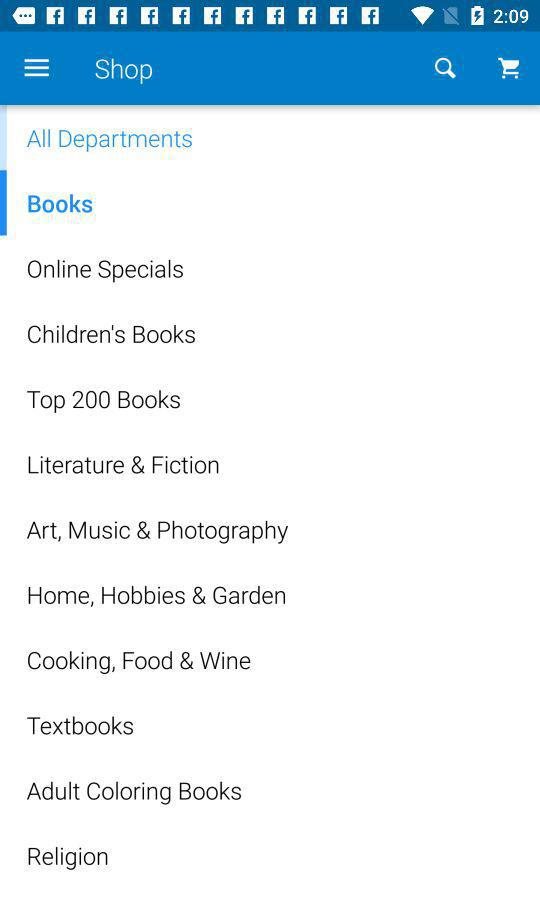

In [15]:
test_image = Image.open("1280.jpg")
test_image

#### Draft screen questions based on the Ferret-UI categories
Using the figure below, draft a list of questions to ask the  model about the above screen. Here are some examples. Please use the provided JSON format. 
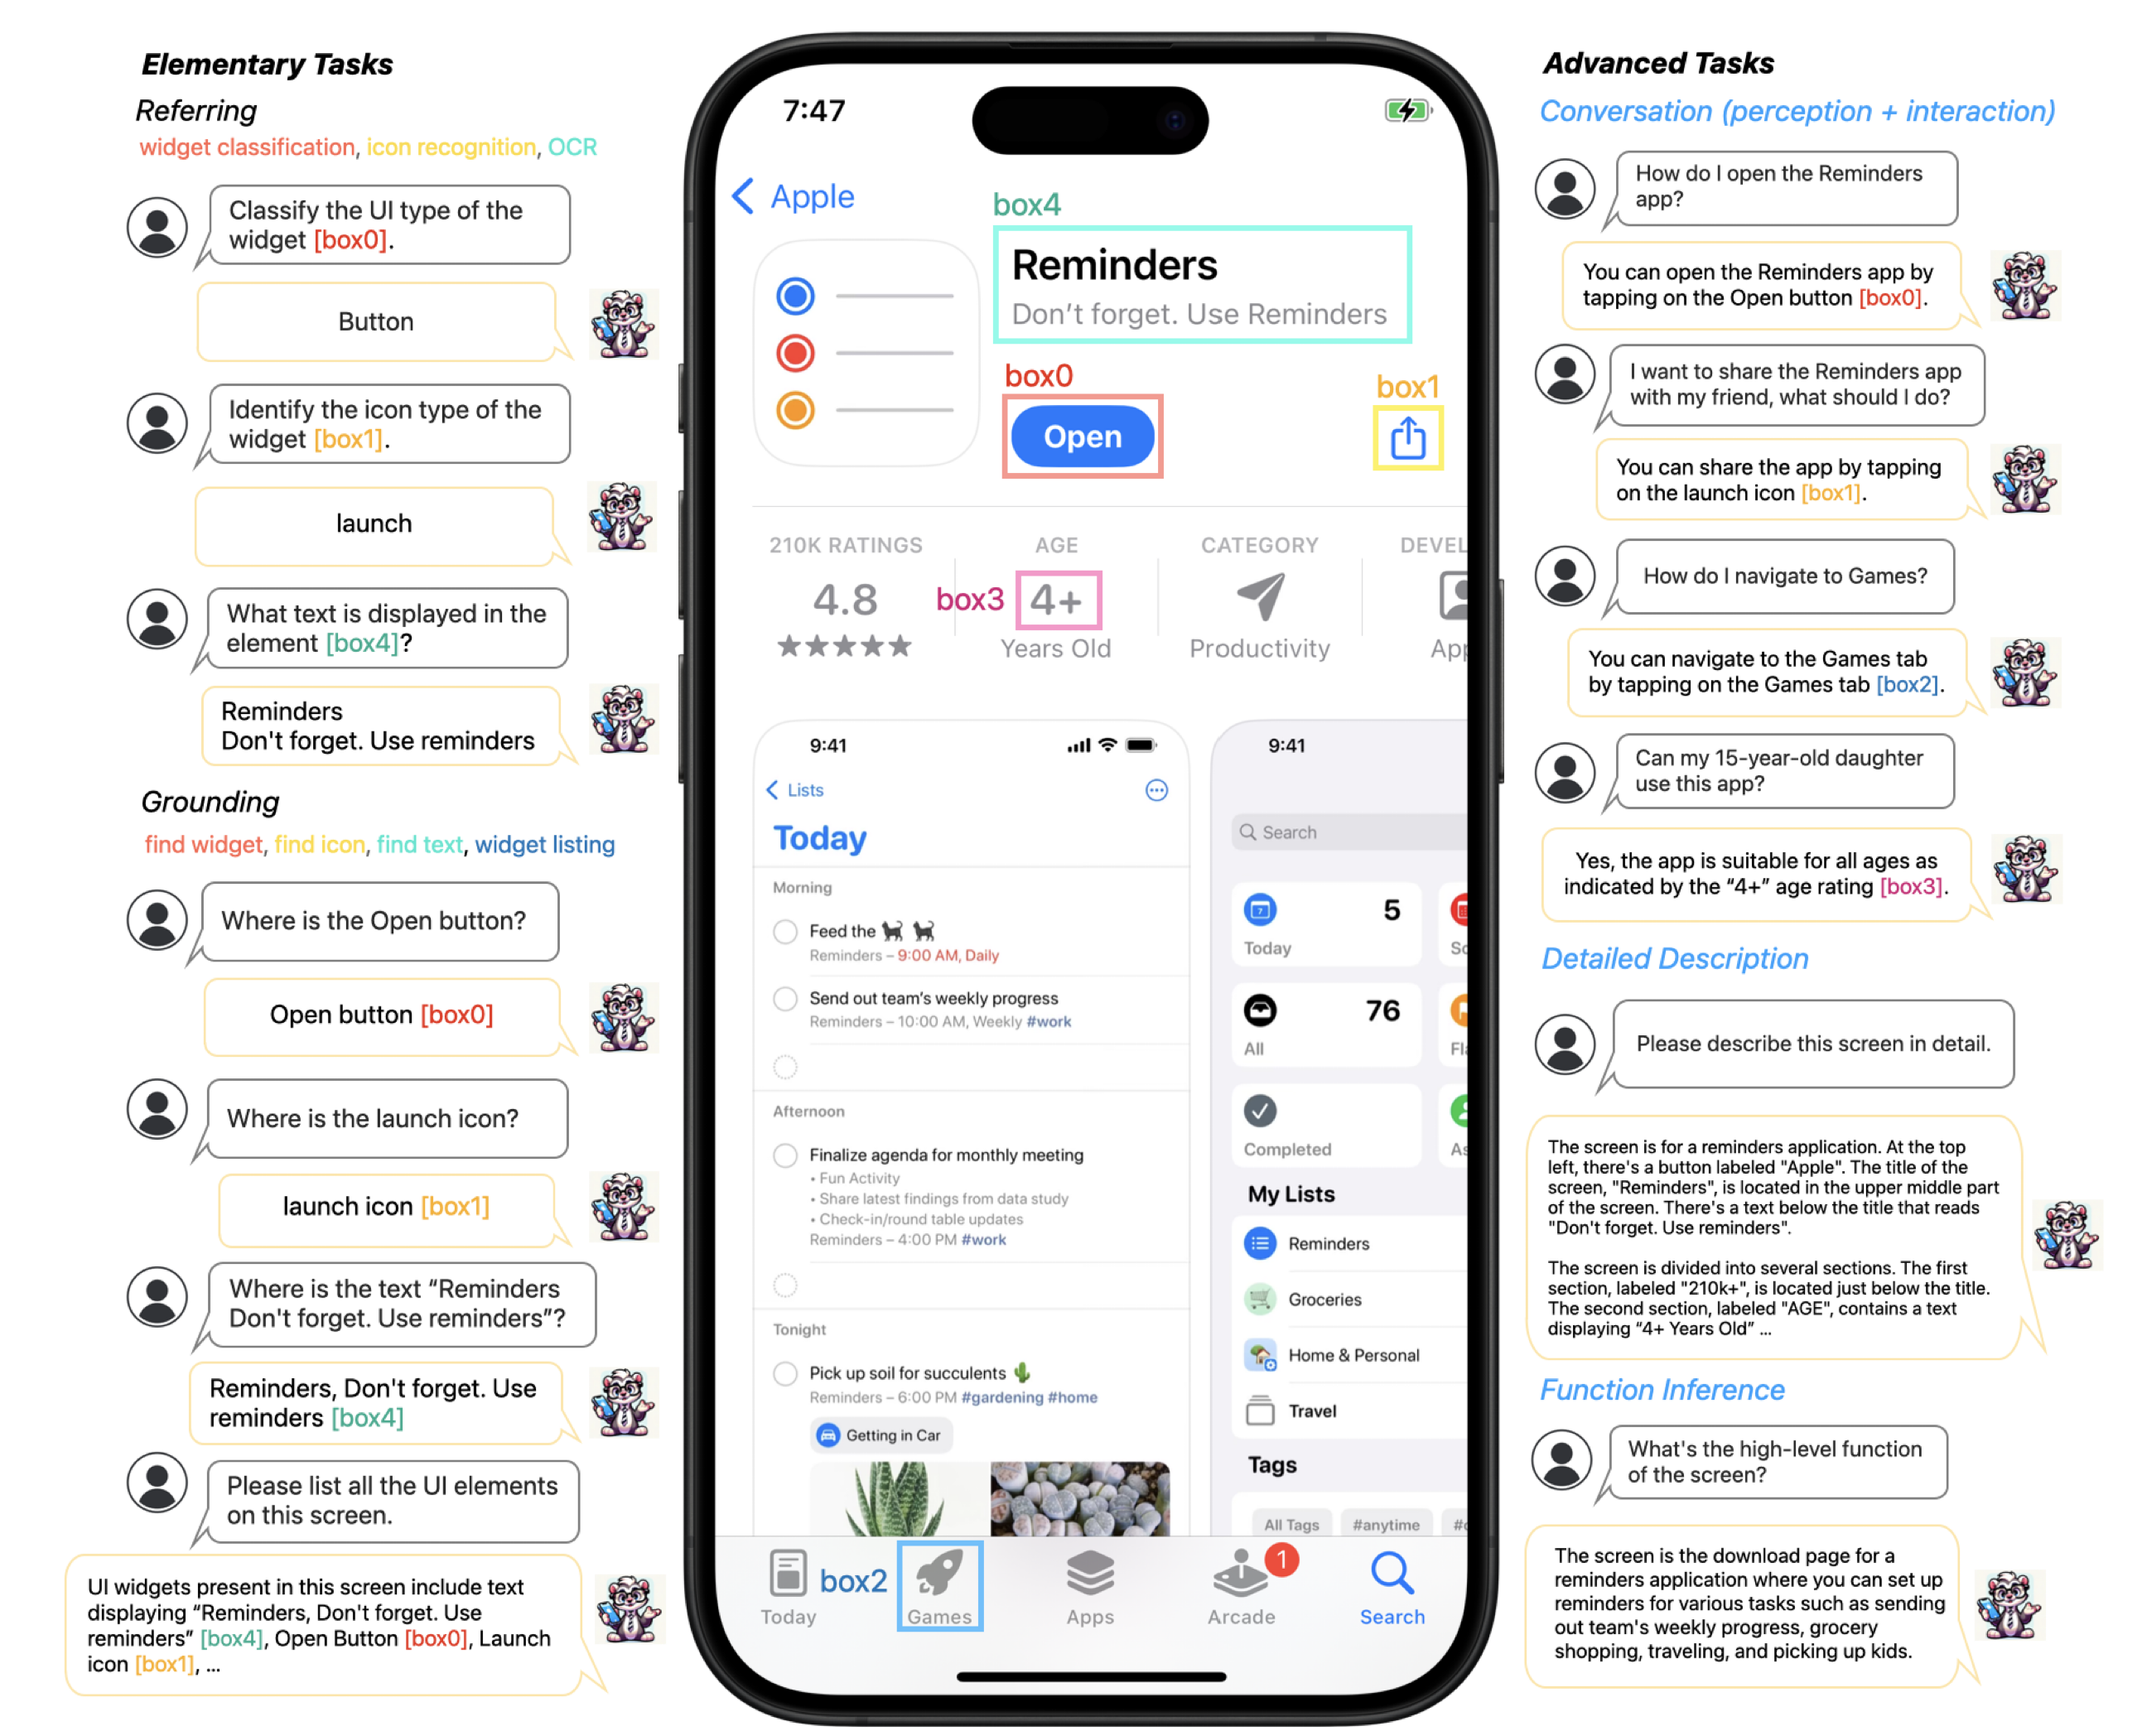

In [16]:
tasks = {
    "referring": {
        "widget_classification": "Classify the UI type of the widget at 442,67.", 
        "icon_recognition": "Identify the icon type of the widget at 442,67.", 
        "ocr": "What text is displayed in the header?"
    }, 
    "grounding": {
        "find widget": "Where is  the religion item?", 
        "find icon": "Where is the hamburger menu icon?", 
        "find text": "Where is the text Shop?", 
        "widget listing": "Please list all the UI elements on this screen."
    }, 
    "conversation": {
        "perception+interaction": "How do I open the shopping cart?", 
        "perception+interaction": "How do I navigate to all departments?", 
        "perception+interaction": "Can i buy books using this app?", 
        "perception": "How many items are in the list?"
    }, 
    "description": {
        "detailed_description": "Please describe this screen in detail.", 
        "function": "What is the high level function of this screen?"
    }, 
}

#### Read in the model you trained earlier to detect UI elements on the screenshot. 

In [17]:
ui_model = loadModel()

Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file downloads/checkpoints/screenrecognition-web350k-vins.ckpt`


In [18]:
pred = getPredictionsForImage(ui_model, test_image)

In [19]:
ui_objects = getUIObjectsForPredictions(pred)

In [20]:
[ui_object.to_str() for ui_object in ui_objects]

['UIObject Box: 31.00, 261.00, 146.00, 19.00,  Class: Text,  Label: , Score: 0.9315329194068909',
 'UIObject Box: 431.00, 57.00, 27.00, 29.00,  Class: Icon,  Label: , Score: 0.8626459836959839',
 'UIObject Box: 29.00, 584.00, 259.00, 23.00,  Class: Text,  Label: , Score: 0.8584742546081543',
 'UIObject Box: 27.00, 325.00, 168.00, 22.00,  Class: Text,  Label: , Score: 0.8534138798713684',
 'UIObject Box: 25.00, 193.00, 70.00, 22.00,  Class: Text,  Label: , Score: 0.8306558728218079',
 'UIObject Box: 29.00, 716.00, 101.00, 19.00,  Class: Text,  Label: , Score: 0.8285273313522339',
 'UIObject Box: 23.00, 58.00, 26.00, 21.00,  Class: Icon,  Label: , Score: 0.8063585162162781',
 'UIObject Box: 96.00, 59.00, 57.00, 21.00,  Class: Text,  Label: , Score: 0.7964034676551819',
 'UIObject Box: 499.00, 57.00, 21.00, 25.00,  Class: Icon,  Label: , Score: 0.769737958908081',
 'UIObject Box: 29.00, 129.00, 163.00, 30.00,  Class: Text,  Label: , Score: 0.7542060613632202',
 'UIObject Box: 34.00, 388.0

#### Draw the predictions on the screenshot

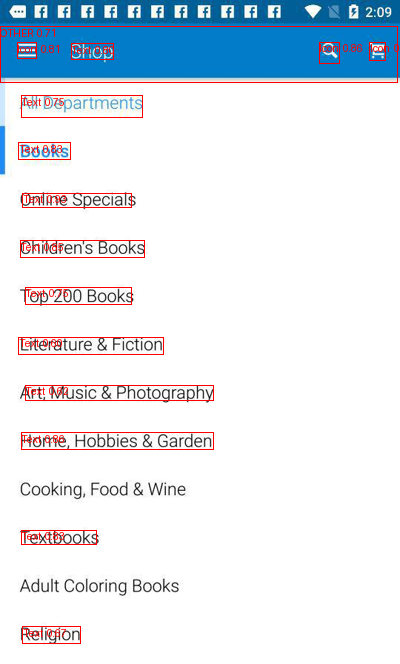

In [21]:
drawUIObjectsOnImage(test_image, ui_objects)

#### Format the ui objects as a string to pass them to the model

In [22]:
formatted_str = ""
for ui_object in ui_objects:
    formatted_str += f"ID: {ui_object.id}, Label: {ui_object.label}, Clickable: {ui_object.clickable}, BoundingBox from ({ui_object.x},{ui_object.y}) to ({ui_object.x+ui_object.width},{ui_object.y+ui_object.height})\n"
print(formatted_str)

ID: 0, Label: Text, Clickable: True, BoundingBox from (31,261) to (177,280)
ID: 1, Label: Icon, Clickable: True, BoundingBox from (431,57) to (458,86)
ID: 2, Label: Text, Clickable: True, BoundingBox from (29,584) to (288,607)
ID: 3, Label: Text, Clickable: True, BoundingBox from (27,325) to (195,347)
ID: 4, Label: Text, Clickable: True, BoundingBox from (25,193) to (95,215)
ID: 5, Label: Text, Clickable: True, BoundingBox from (29,716) to (130,735)
ID: 6, Label: Icon, Clickable: True, BoundingBox from (23,58) to (49,79)
ID: 7, Label: Text, Clickable: True, BoundingBox from (96,59) to (153,80)
ID: 8, Label: Icon, Clickable: True, BoundingBox from (499,57) to (520,82)
ID: 9, Label: Text, Clickable: True, BoundingBox from (29,129) to (192,159)
ID: 10, Label: Text, Clickable: True, BoundingBox from (34,388) to (178,411)
ID: 11, Label: OTHER, Clickable: True, BoundingBox from (0,36) to (537,111)
ID: 12, Label: Text, Clickable: True, BoundingBox from (31,846) to (108,869)
ID: 13, Label: Tex

#### Given the set of UI objects, ask the model questions about the information on the screen. 

In [23]:
for task_level in tasks.keys(): 
    task_level_types = tasks[task_level]
    for task_type in task_level_types.keys(): 
        question = task_level_types[task_type]
        # inputs = processor(test_image, question, return_tensors="pt")
        # out = model.generate(**inputs)
        completion = client.chat.completions.create(
          model=OPENAI_MODEL,
          messages=[
            {"role": "system", "content": "You are a helpful mobile assistant designed to help users use mobile applications. \
                UI elements recognized by an ML model are sometimes provided to help you. "},
            {"role": "user", "content": f"Here are the UI contents of the current screen: {formatted_str}. \n\n{question}"}
          ]
        )

        output_text = completion.choices[0].message.content
        print(f"\n\nQuestion: {question}")
        print(f"Category: {task_level}, Subcategory: {task_type}")
        print(output_text)



Question: Classify the UI type of the widget at 442,67.
Category: referring, Subcategory: widget_classification
The UI type of the widget at coordinates 442,67 is an "Icon". This is based on ID: 1, which has a clickable Icon whose bounding box covers the given coordinates.


Question: Identify the icon type of the widget at 442,67.
Category: referring, Subcategory: icon_recognition
I'm sorry, but as a text-based assistant, I am unable to visually identify the type of the icon. I can identify elements by their descriptors, such as label or ID. However, according to the provided information, the Icon at coordinates (431,57) to (458,86) has an ID of 1 and is clickable.


Question: What text is displayed in the header?
Category: referring, Subcategory: ocr
I'm sorry, I can't provide the specific textual content on your screen as I only have information about the types of elements and their locations. However, the header is typically at the top of the screen. There are a few clickable tex

#### See how adding the Icon classes and text changes the output. 

In [24]:
# Add OCR (hardcoded for this example screenshot above)
with_ocr = addOCRToUIObjects(ui_objects, ocr_for_image)

In [25]:
ids = 0
formatted_str = ""
for ui_object in with_ocr:
    formatted_str += f"ID: {ids}, Label: {ui_object.label}, Text: {ui_object.text}, Clickable: {ui_object.clickable}, BoundingBox from ({ui_object.x},{ui_object.y}) to ({ui_object.x+ui_object.width},{ui_object.y+ui_object.height})\n"
    ids += 1
print(formatted_str)

ID: 0, Label: Text, Text: Online Specials, Clickable: True, BoundingBox from (31,261) to (177,280)
ID: 1, Label: Icon, Text: , Clickable: True, BoundingBox from (431,57) to (458,86)
ID: 2, Label: Text, Text: Home, Hobbies & Garden, Clickable: True, BoundingBox from (29,584) to (288,607)
ID: 3, Label: Text, Text: Children's Books, Clickable: True, BoundingBox from (27,325) to (195,347)
ID: 4, Label: Text, Text: Books, Clickable: True, BoundingBox from (25,193) to (95,215)
ID: 5, Label: Text, Text: Textbooks, Clickable: True, BoundingBox from (29,716) to (130,735)
ID: 6, Label: Icon, Text: =, Clickable: True, BoundingBox from (23,58) to (49,79)
ID: 7, Label: Text, Text: Shop, Clickable: True, BoundingBox from (96,59) to (153,80)
ID: 8, Label: Icon, Text: , Clickable: True, BoundingBox from (499,57) to (520,82)
ID: 9, Label: Text, Text: All Departments, Clickable: True, BoundingBox from (29,129) to (192,159)
ID: 10, Label: Text, Text: Top 200 Books, Clickable: True, BoundingBox from (34,3

#### Ask questions again w/ OCR added

In [26]:
for task_level in tasks.keys(): 
    task_level_types = tasks[task_level]
    for task_type in task_level_types.keys(): 
        question = task_level_types[task_type]
        # inputs = processor(test_image, question, return_tensors="pt")
        # out = model.generate(**inputs)
        completion = client.chat.completions.create(
          model=OPENAI_MODEL,
          messages=[
            {"role": "system", "content": "You are a helpful mobile assistant designed to help users use mobile applications. \
                UI elements recognized by an ML model are sometimes provided to help you. "},
            {"role": "user", "content": f"Here are the UI contents of the current screen: {formatted_str}. \n\n{question}"}
          ]
        )

        output_text = completion.choices[0].message.content
        print(f"\n\nQuestion: {question}")
        print(f"Category: {task_level}, Subcategory: {task_type}")
        print(output_text)



Question: Classify the UI type of the widget at 442,67.
Category: referring, Subcategory: widget_classification
The UI widget at coordinates (442,67) is classified as an Icon (ID: 1).


Question: Identify the icon type of the widget at 442,67.
Category: referring, Subcategory: icon_recognition
Based on the provided UI contents, the coordinates (442,67) fall within the bounding box of ID: 1, which is labeled as an Icon. However, the type or specific details of this icon are not provided in the given information.


Question: What text is displayed in the header?
Category: referring, Subcategory: ocr
The text displayed in the header is "Shop".


Question: Where is  the religion item?
Category: grounding, Subcategory: find widget
The "Religion" item is a text element with ID: 12. It's clickable and located within the bounding box coordinates from (31,846) to (108,869) on the current screen.


Question: Where is the hamburger menu icon?
Category: grounding, Subcategory: find icon
The hamb

#### Add icon classifications to the UI objects

For this Notebook exercise, we will hard code the icon classes based on the formatted IDs in the text string. However, you could also add in the results from an Icon classifier here. 

In [27]:
icon_types = {6: "menu", 1: "search", 8: "shopping cart"}
for ui_object in with_ocr: 
    if ui_object.id in icon_types: 
        ui_object.text = icon_types[ui_object.id]

In [28]:
ids = 0
formatted_str = ""
for ui_object in with_ocr:
    formatted_str += f"ID: {ids}, Label: {ui_object.label}, Text: {ui_object.text}, Clickable: {ui_object.clickable}, BoundingBox from ({ui_object.x},{ui_object.y}) to ({ui_object.x+ui_object.width},{ui_object.y+ui_object.height})\n"
    ids += 1
print(formatted_str)

ID: 0, Label: Text, Text: Online Specials, Clickable: True, BoundingBox from (31,261) to (177,280)
ID: 1, Label: Icon, Text: search, Clickable: True, BoundingBox from (431,57) to (458,86)
ID: 2, Label: Text, Text: Home, Hobbies & Garden, Clickable: True, BoundingBox from (29,584) to (288,607)
ID: 3, Label: Text, Text: Children's Books, Clickable: True, BoundingBox from (27,325) to (195,347)
ID: 4, Label: Text, Text: Books, Clickable: True, BoundingBox from (25,193) to (95,215)
ID: 5, Label: Text, Text: Textbooks, Clickable: True, BoundingBox from (29,716) to (130,735)
ID: 6, Label: Icon, Text: menu, Clickable: True, BoundingBox from (23,58) to (49,79)
ID: 7, Label: Text, Text: Shop, Clickable: True, BoundingBox from (96,59) to (153,80)
ID: 8, Label: Icon, Text: shopping cart, Clickable: True, BoundingBox from (499,57) to (520,82)
ID: 9, Label: Text, Text: All Departments, Clickable: True, BoundingBox from (29,129) to (192,159)
ID: 10, Label: Text, Text: Top 200 Books, Clickable: True, 

#### Ask questions again with the icon types 

In [29]:
for task_level in tasks.keys(): 
    task_level_types = tasks[task_level]
    for task_type in task_level_types.keys(): 
        question = task_level_types[task_type]
        # inputs = processor(test_image, question, return_tensors="pt")
        # out = model.generate(**inputs)
        completion = client.chat.completions.create(
          model=OPENAI_MODEL,
          messages=[
            {"role": "system", "content": "You are a helpful mobile assistant designed to help users use mobile applications. \
                UI elements recognized by an ML model are sometimes provided to help you. "},
            {"role": "user", "content": f"Here are the UI contents of the current screen: {formatted_str}. \n\n{question}"}
          ]
        )

        output_text = completion.choices[0].message.content
        print(f"\n\nQuestion: {question}")
        print(f"Category: {task_level}, Subcategory: {task_type}")
        print(output_text)



Question: Classify the UI type of the widget at 442,67.
Category: referring, Subcategory: widget_classification
The UI type of the widget at coordinates (442,67) is an Icon.


Question: Identify the icon type of the widget at 442,67.
Category: referring, Subcategory: icon_recognition
The icon type of the widget at coordinates (442,67) is 'search'.


Question: What text is displayed in the header?
Category: referring, Subcategory: ocr
The text displayed in the header is "Shop". It is inferred from the UI element ID: 11 which is the highest y-coordinate among all elements identified and it is common for the header to be at the top of the page.


Question: Where is  the religion item?
Category: grounding, Subcategory: find widget
The Religion item is a Text UI element identified by ID 12. It's clickable and its bounding box ranges from coordinates (31,846) to (108,869).


Question: Where is the hamburger menu icon?
Category: grounding, Subcategory: find icon
The hamburger menu icon is r